# Business Valuation of Private Companies Using Multiples: A Regression-Based Approach

--------------

## Table of Contents

1. [Introduction](#Introduction)
2. [Data Import](#Data_Import)
3. [Exploratory Data Analysis](#Exploratory_Data_Analysis)
4. [Data Preparation](#Data_Preparation)
   
    4.1 [Column names standardization](#Column_names_standardization)
    
    4.2 [Conversion of data types](#Conversion_of_data_types)
    
    4.3 [Merging data](#Merging_data)
    
    4.4 [Adjusting the data](#Adjusting_the_data)
    
    4.5 [Defining additional variables](#Defining_additional_variables)

5. [Modeling](#Modeling)

    5.1 [Calculating multiples using location parameters](#Calculating_multiples_using_location_parameters)
    
    5.2 [Calculating multiples using simple linear regression analysis](#Calculating_multiples_using_simple_linear_regression_analysis)
    
    5.3 [Calculating multiples using a log-log regression model](#Calculating_multiples_using_a_log-log_regression_model)
    
    5.4 [Calculating multiples using multiple linear regression model](#Calculating_multiples_using_multiple_linear_regression_model)
    
    5.5 [Calculating multiples using seemingly unrelated regression model](#Calculating_multiples_using_seemingly_unrelated_regression_model)

6. [Evaluation](#Evaluation)

    6.1 [t-test, p-value and confidence intervals](#t-test_p-value_and_confidence_intervals)
    
    6.2 [Chow test](#Chow_test)

7. [Prediction](#Prediction)
   

--------------

## 1. Introduction <a id='Introduction'></a>

In this analysis, we take on the role of employees in the M&A department of a consulting firm, tasked with conducting business valuations for clients planning to acquire unlisted family businesses. Unlike publicly traded companies, private businesses lack a readily available market price, posing a challenge in determining their value. To address this, we aim to estimate company value using multiples, which allow us to compare similar companies based on financial drivers.

Our analysis focuses on developing a valuation model using simple and multiple linear regressions, leveraging available data that includes enterprise values, value drivers, and industry affiliations of comparable companies. By analysing these factors, we seek to understand how multiples are formed and assess their validity in estimating enterprise value. Additionally, we consider potential heterogeneity across industries to ensure the robustness of our valuation approach.

--------------

## 2. Data Import <a id='Data_Import'></a>

We start by loading the necessary libraries for subsequent analysis.

[Code section 1]

In [1]:
# IMPORTING LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import os
import urllib.request
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
from linearmodels.system import SUR
from collections import OrderedDict
from scipy.stats import hmean


For this case study, we utilize data sourced from the platform Kaggle. The analysis will be conducted using the following datasets:

- `prices-split-adjusted.csv`: This dataset provides daily share prices for the period 2010 to 2016, with adjustments already made for stock splits (so that we can assume consistency and comparability over time).
- `securities.csv`: This dataset contains additional company-specific information, including industry classification, which is crucial for our sector-based analysis.
- `fundamentals.csv`: This dataset includes fundamental financial figures extracted from SEC 10-K filings spanning the period 2012 to 2016. SEC 10-K filings are standardized financial reports that companies meeting certain criteria are required to submit to the U.S. Securities and Exchange Commission (SEC). These filings contain comprehensive financial statements and disclosures essential for our valuation analysis.

The data is provided in the form of multiple CSV files, which we import in the following code cell.

[Code section 2]

In [2]:
# IMPORTING DATASETS

df_fundamentals = pd.read_csv("fundamentals.csv", index_col=0)
df_prices_split = pd.read_csv("prices-split-adjusted.csv")
df_securities = pd.read_csv("securities.csv")

--------------

## 3. Exploratory Data Analysis <a id='Exploratory_Data_Analysis'></a>

We proceed by providing a summary of the DataFrames using the `info()` method, which returns information about the DataFrame, including the data type of each column, the number of non-null values in each column, and the memory usage of the DataFrame.

[Code section 3]

In [3]:
# INFO METHOD

print("The information of the \"Fundamentals\" data-frame is:")
display(df_fundamentals.info())

print("The information of the \"Price Split\" data-frame is:")
display(df_prices_split.info())

print("The information of the \"Securities\" data-frame is:")
display(df_securities.info())

The information of the "Fundamentals" data-frame is:
<class 'pandas.core.frame.DataFrame'>
Index: 1781 entries, 0 to 1780
Data columns (total 78 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Ticker Symbol                                        1781 non-null   object 
 1   Period Ending                                        1781 non-null   object 
 2   Accounts Payable                                     1781 non-null   float64
 3   Accounts Receivable                                  1781 non-null   float64
 4   Add'l income/expense items                           1781 non-null   float64
 5   After Tax ROE                                        1781 non-null   float64
 6   Capital Expenditures                                 1781 non-null   float64
 7   Capital Surplus                                      1781 non-null   float64
 8   Cash Ratio          

None

The information of the "Price Split" data-frame is:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


None

The information of the "Securities" data-frame is:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Ticker symbol            505 non-null    object
 1   Security                 505 non-null    object
 2   SEC filings              505 non-null    object
 3   GICS Sector              505 non-null    object
 4   GICS Sub Industry        505 non-null    object
 5   Address of Headquarters  505 non-null    object
 6   Date first added         307 non-null    object
 7   CIK                      505 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 31.7+ KB


None

--------------

## 4. Data Preparation <a id='Data_Preparation'></a>

### 4.1 Column names standardization <a id='Column_names_standardization'></a>

From the exploratory data analysis, we noticed that the column names contain spaces. Hence, we standardize the column names across all datasets by replacing spaces with dots. This step ensures consistency and simplifies data handling, making it easier to reference and manipulate columns in subsequent analyses.

[Code section 4]

In [4]:
# STANDARDIZING COLUMN NAMES

df_fundamentals.columns = [c.replace(' ', '.') for c in df_fundamentals.columns]
df_prices_split.columns = [c.replace(' ', '.') for c in df_prices_split.columns]
df_securities.columns = [c.replace(' ', '.') for c in df_securities.columns]

### 4.2 Conversion of data types <a id='Conversion_of_data_types'></a>

From the exploratory data analysis, we also noticed that an overview of the content and structure of the imported data reveals that some attributes are assigned incorrect data types, therefore, we convert the data types of the columns to the appropriate format.

[Code section 5]

In [5]:
# CHECKING TYPE OF VARIABLES

df_prices_split['date'] = pd.to_datetime(df_prices_split['date'], format='%Y-%m-%d')
df_securities['Date.first.added'] = pd.to_datetime(df_securities['Date.first.added'], format='%Y-%m-%d')
df_securities['CIK'] = df_securities.CIK.astype('category')
df_securities['Security'] = df_securities.Security.astype('category')
df_securities['GICS.Sub.Industry'] = df_securities['GICS.Sub.Industry'].astype('category')
df_securities['GICS.Sector'] = df_securities['GICS.Sector'].astype('category')
df_securities['Address.of.Headquarters'] = df_securities['Address.of.Headquarters'].astype('category')
df_securities['SEC.filings'] = df_securities['SEC.filings'].astype('category')
df_fundamentals['Period.Ending'] = pd.to_datetime(df_fundamentals['Period.Ending'], format='%Y-%m-%d')

### 4.3 Merging data <a id='Merging_data'></a>

To consolidate all relevant financial data, we perform a series of merge operations across the datasets. 

First, we merge `df_fundamentals` with `df_prices_split` using a common key consisting of the columns `Period.Ending` and `Ticker.Symbol` from the fundamentals dataset, and `date` and `symbol` from the prices dataset. After the merge, the redundant columns `date` and `symbol` from the prices dataset are dropped to avoid redundancy.

Then, we further merge `df_merge1` with `df_securities` using the `Ticker.Symbol` column as the common key. The duplicate column `Ticker.symbol` from the securities dataset is subsequently dropped to avoid redundancy.


[Code section 6]

In [6]:
df_merge1 = df_fundamentals.merge(df_prices_split, left_on = ['Period.Ending','Ticker.Symbol'], right_on = ['date', 'symbol'])
df_merge1 = df_merge1.drop(['date', 'symbol'], axis=1)

df_merge2 = df_merge1.merge(df_securities, left_on='Ticker.Symbol', right_on='Ticker.symbol')
df_merge2 = df_merge2.drop('Ticker.symbol', axis=1)

### 4.4 Adjusting the data <a id='Adjusting_the_data'></a>

The multiple is generally sector-specific. As the financial sector (banks, insurance companies and other financial institutions) differs fundamentally from other sectors in terms of company valuation using multiples, observations from this sector are excluded from further consideration.


[Code section 7]

In [7]:
# EXCLUDING FINANCIAL SECTOR

df_merge2 = df_merge2[df_merge2['GICS.Sector'] != 'Financials']


In this stage, we identify and remove any records containing missing values across the merged dataset. Eliminating such records helps prevent potential biases and inconsistencies that could arise during the modeling phase. We also handle useless data values to ensure data quality and consistency.

[Code section 8]

In [8]:
# HANDLING MISSING AND USELESS VALUES

# Remove rows containing NA
df_merge2 = df_merge2.dropna(subset=['Estimated.Shares.Outstanding'])

#Remove entries that are not reasonable
df_merge2 = df_merge2[df_merge2['Earnings.Before.Tax']>0]
df_merge2 = df_merge2[df_merge2['Short-Term.Debt./.Current.Portion.of.Long-Term.Debt']>0]
df_merge2 = df_merge2[df_merge2['Estimated.Shares.Outstanding']>0]
df_merge2 = df_merge2[df_merge2['Sales,.General.and.Admin.']>0]

# Filter 'Period.Ending' for the last day of each years
df_ana12to15 = df_merge2[(df_merge2['Period.Ending'] == '2012-12-31') | 
        (df_merge2['Period.Ending'] == '2013-12-31') |
        (df_merge2['Period.Ending'] == '2014-12-31') |
        (df_merge2['Period.Ending'] == '2015-12-31')]

df_ana12to15['Period.Ending'] = pd.DatetimeIndex(df_ana12to15['Period.Ending']).year



### 4.5 Defining additional variables <a id='Defining_additional_variables'></a>

The variables Enterprise Value (EV) and EBITDA, which are important value drivers for the analysis, are not directly available in the dataset `df_ana12to15`. However, they can be derived using existing financial data. 

- EBITDA (Earnings Before Interest, Taxes, Depreciation, and Amortization) is calculated by summing Earnings Before Interest and Tax (EBIT) and Depreciation, providing a measure of a company's operating performance.  
  
- Enterprise Value (EV) is computed using the formula:  
  
  $$EV = \text{Market Value of Equity (stock price * outstanding shares)} + \text{Total Liabilities} - \text{Cash and Cash Equivalents}$$

[Code section 9]

In [9]:
# COMPUTING EBITDA AND ENTERPRISE VALUE

df_ana12to15['EBITDA'] = df_ana12to15['Earnings.Before.Interest.and.Tax'] + df_ana12to15['Depreciation'] 
df_ana12to15['EV'] = df_ana12to15['close']*df_ana12to15['Estimated.Shares.Outstanding']+df_ana12to15['Total.Liabilities']-df_ana12to15['Cash.and.Cash.Equivalents']

--------------

## 5. Modeling <a id='Modeling'></a>

### 5.1 Calculating multiples using location parameters <a id='Calculating_multiples_using_location_parameters'></a>

In the following code sections, our aim is to estimate the enterprise value of the private companies in the Health Care sector by leveraging valuation multiples. Since private companies lack market prices, we calculate the EV/EBITDA multiple using historical data from similar companies and apply three statistical measures, arithmetic mean, median, and harmonic mean, to derive valuation estimates. By comparing the estimated values to actual enterprise values, we assess the accuracy of each method and identify which statistical approach provides the most reliable valuation for informed decision-making.

[Code section 10]

In [10]:
# FILTERING THE DATA FOR THE HEALTH CARE SECTOR (2012-2014)

df_HC = df_ana12to15[(df_ana12to15['GICS.Sector'] == 'Health Care') & 
                    (df_ana12to15['Period.Ending'].isin([2012, 2013, 2014]))]

df_HC.head()

,Ticker.Symbol,Period.Ending,Accounts.Payable,Accounts.Receivable,Add'l.income/expense.items,After.Tax.ROE,Capital.Expenditures,Capital.Surplus,Cash.Ratio,Cash.and.Cash.Equivalents,...,volume,Security,SEC.filings,GICS.Sector,GICS.Sub.Industry,Address.of.Headquarters,Date.first.added,CIK,EBITDA,EV
4,ABBV,2013,6.448000e+09,681000000.0,-54000000.0,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,...,3019700.0,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,6.507000e+09,9.960700e+10
5,ABBV,2014,6.954000e+09,-172000000.0,-651000000.0,102.0,-6.120000e+08,4.194000e+09,74.0,8.348000e+09,...,3917300.0,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,3.546000e+09,1.220091e+11
12,ABT,2013,5.948000e+09,-113000000.0,53000000.0,10.0,-1.145000e+09,0.000000e+00,85.0,3.475000e+09,...,4594200.0,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,3.905000e+09,7.451315e+10
13,ABT,2014,5.350000e+09,-195000000.0,69000000.0,11.0,-1.077000e+09,0.000000e+00,43.0,4.063000e+09,...,3418600.0,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,4.216000e+09,8.416845e+10
74,ALXN,2013,4.239400e+08,-116439000.0,2371000.0,11.0,-2.932900e+07,2.106183e+09,260.0,5.298570e+08,...,455600.0,Alexion Pharmaceuticals,reports,Health Care,Biotechnology,"Cheshire, Connecticut",2012-05-25,899866,5.623090e+08,2.645591e+10


[Code section 11]

In [11]:
# COMPUTING EV/EBITDA MULTIPLE FOR EACH COMPANY

df_HC['EV_EBITDA'] = df_HC['EV'] / df_HC['EBITDA']

# Removing potential infinite or NaN values caused by zero EBITDA
df_HC = df_HC[df_HC['EBITDA'] > 0].dropna(subset=['EV_EBITDA'])

[CODE SECTION 12]

In [12]:
# DETERMINING MULTIPLES USING LOCATION PARAMETERS

arithmetic_mean = df_HC['EV_EBITDA'].mean()
median = df_HC['EV_EBITDA'].median()
harmonic_mean = hmean(df_HC['EV_EBITDA'])

print("Arithmetic Mean: ", arithmetic_mean)
print("Median: ", median)
print("Harmonic Mean: ", harmonic_mean)

Arithmetic Mean:  18.69532406808113
Median:  15.393297892888963
Harmonic Mean:  14.313528204907982


[Code section 13]

In [13]:
# COMPUTING COMPANY VALUES USING MULTIPLES

df_HC['EV_arithmetic'] = df_HC['EBITDA'] * arithmetic_mean
df_HC['EV_median'] = df_HC['EBITDA'] * median
df_HC['EV_harmonic'] = df_HC['EBITDA'] * harmonic_mean

[Code section 14]

,error_arithmetic,error_median,error_harmonic
count,68.000000,68.000000,6.800000e+01
mean,0.306130,0.075437,1.608191e-16
std,0.563514,0.463984,4.314378e-01
min,-0.843329,-0.871001,-8.800493e-01
25%,-0.114777,-0.271128,-3.222547e-01
50%,0.214548,0.000031,-7.011667e-02
75%,0.834211,0.510247,4.043102e-01
max,1.547695,1.097714,9.505686e-01


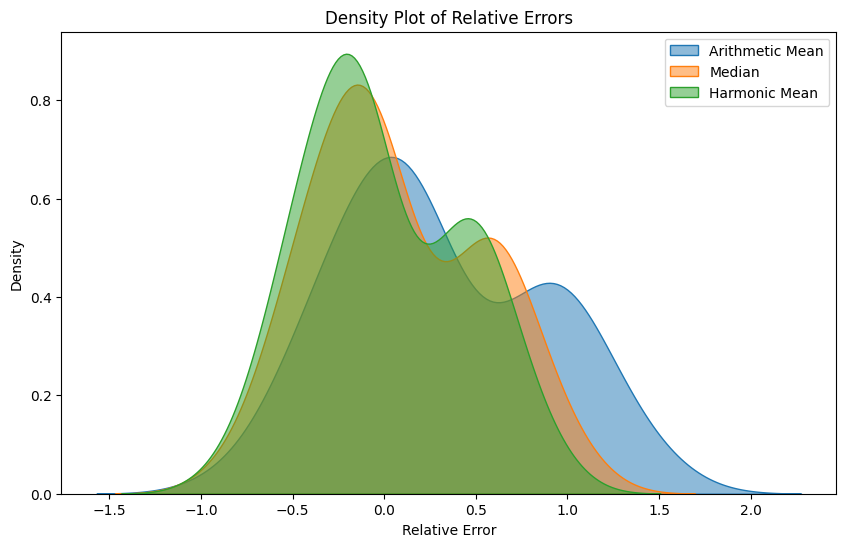

In [14]:
# COMPUTING RELATIVE ERRORS

# computing relative errors
df_HC['error_arithmetic'] = (df_HC['EV_arithmetic'] - df_HC['EV']) / df_HC['EV']
df_HC['error_median'] = (df_HC['EV_median'] - df_HC['EV']) / df_HC['EV']
df_HC['error_harmonic'] = (df_HC['EV_harmonic'] - df_HC['EV']) / df_HC['EV']

display(df_HC[['error_arithmetic', 'error_median', 'error_harmonic']].describe())

# Plotting density curves for the relative errors
plt.figure(figsize=(10, 6))
sns.kdeplot(df_HC['error_arithmetic'], label="Arithmetic Mean", fill=True, alpha=0.5)
sns.kdeplot(df_HC['error_median'], label="Median", fill=True, alpha=0.5)
sns.kdeplot(df_HC['error_harmonic'], label="Harmonic Mean", fill=True, alpha=0.5)

plt.title("Density Plot of Relative Errors")
plt.xlabel("Relative Error")
plt.ylabel("Density")
plt.legend()
plt.show()

From the results above, we observe that:

- The arithmetic mean tends to overestimate enterprise value, as indicated by the highest mean error (0.306) and a wide standard deviation (0.563). This suggests that the arithmetic mean is sensitive to outliers and might produce inflated valuations.
- The median, with a mean error of 0.075, provides a more balanced and reliable estimate, as it is less affected by extreme values. The median’s standard deviation (0.464) is lower than that of the arithmetic mean, indicating relatively more consistent estimates.
- The harmonic mean, with a near-zero mean error (1.61e-16), appears to provide the most accurate estimates on average. However, its standard deviation (0.431) suggests some variability, and its range (-0.88 to 0.95) indicates it might underestimate values in some cases.

Therefore, in this case, the median appears to provide the most reliable and stable valuation method, balancing estimation accuracy while minimizing extreme deviations compared to the arithmetic and harmonic means.

### 5.2 Calculating multiples using simple linear regression analysis <a id='Calculating_multiples_using_simple_linear_regression_analysis'></a>

We now aim to estimate a simple linear regression model using the appropriately processed dataset `df_ana12to15`. The goal of this model is to predict Enterprise Value (EV), which serves as the dependent variable, using EBITDA as the independent variable. By applying linear regression, we assume a direct relationship between EBITDA and EV, allowing us to quantify how changes in EBITDA impact the company's enterprise value.

[Code section 15]

In [15]:
# ESTIMATING A SIMPLE LINEAR REGRESSION MODEL 

reg1 = sm.OLS(df_ana12to15['EV'], sm.add_constant(df_ana12to15['EBITDA'])).fit()
reg1.params

const     1.772406e+10
EBITDA    8.238525e+00
dtype: float64

The estimated coefficients of the simple linear regression model `reg1` can be accessed via `reg1.params`. The regression equation is given as:

$$ \hat{y} = 1.772 + 8.238525 \cdot x $$

where:  
- $\hat{y}$ represents the predicted Enterprise Value (EV),  
- $x$ represents EBITDA,  
- $\hat{\beta_0} = 1.772$ is the intercept, representing the estimated enterprise value when EBITDA is zero,  
- $\hat{\beta_1} = 8.238525$ is the slope coefficient, indicating the impact of changes in EBITDA on EV.

This means that for every increase of 1 million USD in EBITDA, the enterprise value is expected to increase by 8.238525 million USD, assuming all other factors remain constant. The positive coefficient suggests a strong linear relationship between EBITDA and EV, reinforcing the idea that higher earnings before interest, taxes, depreciation, and amortization contribute significantly to a company's overall valuation.

To better understand the relationship between EBITDA and Enterprise Value (EV), we generate a scatter plot using the processed dataset df_ana12to15. The plot visualizes the distribution of data points, with EBITDA on the x-axis and Enterprise Value (EV) on the y-axis.

[Code section 16]

In [16]:
# PLOTTING THE REGRESSION LINE FOR THE SIMPLE LINEAR REGRESSION MODEL

fig = px.scatter(
    df_ana12to15, x='EBITDA', y='EV', opacity=0.65,
    trendline='ols', trendline_color_override='darkblue'
)
fig

### 5.3 Calculating multiples using a log-log regression model <a id='Calculating_multiples_using_a_log-log_regression_model'></a>

We aim to assess the relationship between Enterprise Value (EV) and EBITDA while addressing potential issues related to skewness and variance in the data. To achieve this, we first examine the distribution of these variables and subsequently apply logarithmic transformations before conducting regression modeling.

Therefore, we start by determining whether EV and EBITDA follow a normal distribution by analysing their histograms. Visual inspection of the above scatter plot, makes us expect that both variables will exhibit right-skewness, characterized by a concentration of observations on the lower end and a long tail extending to the right.

[Code section 17]

In [17]:
# PLOTTING THE DISTRIBUTION OF EV

hist_data = [df_ana12to15['EV'].to_numpy()]
group_labels = ['EV'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, bin_size=1000000000)
fig.show()

[Code section 18]

In [18]:
# PLOTTING THE DISTRIBUTION OF EBIDTA

hist_data = [df_ana12to15['EBITDA'].to_numpy()]
group_labels = ['EBITDA'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, bin_size=1000000000)
fig.show()


The plots clearly show that both EV and EBITDA distributions are right skewed, which indicates that the variables are not normally distributed, which in turn may impact the assumptions required for statistical modeling. Hence, we apply a logarithmic transformation to reduce skewness and stabilize variance, making the data more suitable for a regression analysis.

[Code section 19]

In [19]:
# LOGARITHMIC TRANSFORMATION

df_ana12to15['lgEBITDA'] = np.log(df_ana12to15['EBITDA'])
df_ana12to15['lgEV'] = np.log(df_ana12to15['EV'])

Now, we examine the distributions of the log-transformed variables (lgEV and lgEBITDA) to assess whether the transformation has effectively addressed the skewness observed in the original data.

[Code section 20]

In [20]:
hist_data = [df_ana12to15['lgEV'].to_numpy()]
group_labels = ['lgEV'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, bin_size=1000000000)
fig.show()

[Code section 21]

In [21]:
hist_data = [df_ana12to15['lgEBITDA'].to_numpy()]
group_labels = ['lgEBITDA'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, bin_size=1000000000)
fig.show()

Now, the plots exhibit a more symmetric and approximately bell-shaped distribution, indicating that the logarithmic transformation has successfully mitigated the right-skewness. This transformation not only improves normality but also helps stabilize variance, making the data more suitable for further statistical analysis.

With the transformed data, we proceed to estimate a log-log regression model, where both the dependent and independent variables are expressed in logarithmic form. This transformation allows us to interpret the regression coefficients in terms of elasticity, meaning that the estimated coefficients represent the percentage change in the dependent variable for a $1\%$ change in the independent variable.

The regression is estimated using the following model:

$$\log(\text{EV}) = \beta_0 + \beta_1 \log(\text{EBITDA}) + \varepsilon$$

[Code section 22]

In [22]:
# ESTIMATING A LOG-LOG REGRESSION MODEL
df_ana12to15_OLS = df_ana12to15[['lgEV', 'lgEBITDA']]
reg2 = sm.OLS(df_ana12to15['lgEV'], sm.add_constant(df_ana12to15['lgEBITDA'])).fit()

reg2.params

const       5.709051
lgEBITDA    0.857239
dtype: float64

The estimated coefficients from the log-log regression model indicate that the relationship between Enterprise Value (EV) and EBITDA follows a positive and significant trend. Specifically, the coefficient for lgEBITDA is approximately $0.857$, suggesting that a $1\%$ increase in EBITDA is associated with an estimated $0.86\%$ increase in EV, holding all else constant. The intercept term of $5.709$ represents the expected log of EV when EBITDA is at its baseline level (i.e., $0$).

To further visualize the relationship between the log-transformed variables and assess the model fit, we generate a scatterplot of the observed values with the fitted regression line.

[Code section 23]

In [23]:
# PLOTTING THE REGRESSION LINE FOR THE LOG-LOG MODEL

fig = px.scatter(
    df_ana12to15, x='lgEBITDA', y='lgEV', opacity=0.65,
    trendline='ols', trendline_color_override='darkblue'
)

fig

The scatterplot above visually confirms the positive relationship identified in the regression results. Compared to the original linear regression model, where a large portion of the data was concentrated in the right part of the plot, the log-log transformation results in a more evenly distributed data pattern across the entire range. This transformation helps to mitigate the effect of extreme values and allows for a better visualization of the underlying relationship.

### 5.4 Calculating multiples using multiple linear regression model <a id='Calculating_multiples_using_multiple_linear_regression_model'></a>

In the two regression models estimated thus far, the dataset has been treated as cross-sectional, meaning that observations were analysed without considering temporal or sectoral dimensions. As a result, time-specific and sector-specific effects were not accounted for, and a pooled regression was performed. This approach assumed that the relationship between EV and EBITDA remains stable over time and across different sectors.

However, in reality, valuation multiples can fluctuate due to various factors such as macroeconomic conditions, industry trends, and firm-specific characteristics. Ignoring these variations may lead to biased or incomplete conclusions. Incorporating panel data techniques, such as fixed or random effects models, could provide a more accurate representation by capturing heterogeneity across time periods and sectors.

To further refine the analysis, we begin with additional data preparation steps specific to this model. An important aspect of panel data analysis is understanding the distribution of observations across time periods and sectors. Hence, we analyze the number of observations per sector and year to identify potential imbalances in the dataset.

[Code section 24]

In [24]:
# EXAMINING THE SECTORAL DISTRIBUTION OF COMPANIES OVER THE YEARS

tab = df_ana12to15.groupby(['GICS.Sector', 'Period.Ending']).size()
tab.unstack()

/var/folders/cx/d9r8ycpn4817gbsnr_jkv9640000gn/T/ipykernel_67411/1686569946.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Period.Ending,2012,2013,2014,2015
GICS.Sector,,,,
Consumer Discretionary,13,21,20,20
Consumer Staples,6,11,11,11
Energy,17,25,20,9
Financials,0,0,0,0
Health Care,17,25,26,25
Industrials,18,42,47,45
Information Technology,9,17,17,17
Materials,14,14,18,16
Real Estate,13,13,15,16


The resulting table reveals that the number of observations varies (and specifically increases) across different years, indicating the presence of an unbalanced panel, where some enterprises do not have data available for all time periods.

To simplify the analysis and ensure consistency in subsequent steps, we reduce the dataset to include only those enterprises with observations available for all four years. This results in a balanced panel, which facilitates easier interpretation and modeling.

First, we convert the  `Ticker.Symbol` column to a categorical data type to facilitate efficient processing. We then count the occurrences of each ticker symbol to determine the number of observations available for each enterprise.

[Code section 25]

In [25]:
# IDENTIFYING COMPANIES THAT HAVE REPORTED DATA FOR ALL FOUR YEARS

df2 = df_ana12to15
df2['Ticker.Symbol'] = df2['Ticker.Symbol'].astype('category')
tab2 = df2.groupby(['Ticker.Symbol']).size()

/var/folders/cx/d9r8ycpn4817gbsnr_jkv9640000gn/T/ipykernel_67411/2205135936.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Then, to retain only those enterprises with data available for all four years, we filter the dataset by selecting ticker symbols that appear exactly four times.

[Code section 26]

In [26]:
# FILTERING FOR BALANCED PANEL

indices = (tab2==4)
df_panel = df_ana12to15[df_ana12to15['Ticker.Symbol'].isin(tab2.loc[indices].index.values)]

Finally, we analyze the sectoral distribution of firms within the balanced panel, focusing on a specific year. This helps to understand the composition of the dataset across different industry sectors.

[Code section 27]

In [27]:
# SECTORAL ANALYSIS OF THE BALANCED PANEL

gics = df_panel[df_panel['Period.Ending']==2012]
gics.groupby(['GICS.Sector']).size()

/var/folders/cx/d9r8ycpn4817gbsnr_jkv9640000gn/T/ipykernel_67411/56824520.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



GICS.Sector
Consumer Discretionary          8
Consumer Staples                6
Energy                          5
Financials                      0
Health Care                    14
Industrials                    15
Information Technology          9
Materials                       9
Real Estate                     9
Telecommunications Services     3
Utilities                      15
dtype: int64

To proceed with model development and evaluation, we split the balanced panel dataset into training and test subsets, in order to build and validate the model's predictive performance.

[Code section 28]

In [28]:
# SPLITTING THE DATA INTO TRAIN AND TEST DATASETS

df_test = df_panel[df_panel['Period.Ending']==2015]
df_train = df_panel[df_panel['Period.Ending'].isin([2012,2013,2014])]

We now focus on comparing two specific sectors: Industrials and Information Technology. These sectors are expected to exhibit different financial behaviour and market dynamics, making it valuable to analyze them separately.

[Code section 29]

In [29]:
# SELECTING TWO SECTORS

sec1 = "Industrials"
sec2 = "Information Technology"

To estimate the models for the dataset at hand, the training data (df_train) is further divided into subsets based on sector and time period. This structured segmentation allows for more granular analysis of the relationship between Enterprise Value (EV) and EBITDA, considering both sector-specific and time-specific effects.

[Code section 30]

In [30]:
# BUILDING SUBSETS FOR THE TWO SECTORS

# Build subset for (Mod1): combined sector analysis
dat_s1s2 = df_train[df_train['GICS.Sector'].isin([sec1,sec2])]
dat_s1s2_OLS = dat_s1s2[['lgEV', 'lgEBITDA']]

# Build subset for (Mod2): sector analysis by year
dat_s1s2_12 = df_train[(df_train['Period.Ending'] == 2012) & (df_train['GICS.Sector'].isin([sec1,sec2]))]
dat_s1s2_12_OLS = dat_s1s2_12[['lgEV', 'lgEBITDA']]
dat_s1s2_13 = df_train[(df_train['Period.Ending'] == 2013) & (df_train['GICS.Sector'].isin([sec1,sec2]))]
dat_s1s2_13_OLS = dat_s1s2_13[['lgEV', 'lgEBITDA']]
dat_s1s2_14 = df_train[(df_train['Period.Ending'] == 2014) & (df_train['GICS.Sector'].isin([sec1,sec2]))]
dat_s1s2_14_OLS = dat_s1s2_14[['lgEV', 'lgEBITDA']]

# Build subset for (Mod3): individual sector analysis
dat_s1 = df_train[(df_train['GICS.Sector']==sec1)]
dat_s1_OLS = dat_s1[['lgEV', 'lgEBITDA']]

dat_s2 = df_train[(df_train['GICS.Sector']==sec2)]
dat_s2_OLS = dat_s2[['lgEV', 'lgEBITDA']]

# Build subset for (Mod4): sector - year analysis
dat_s1_12 = df_train[(df_train['Period.Ending']==2012) & (df_train['GICS.Sector']==sec1)]
dat_s1_12_OLS = dat_s1_12[['lgEV', 'lgEBITDA']]

dat_s1_13 = df_train[(df_train['Period.Ending']==2013) & (df_train['GICS.Sector']==sec1)]
dat_s1_13_OLS = dat_s1_13[['lgEV', 'lgEBITDA']]

dat_s1_14 = df_train[(df_train['Period.Ending']==2014) & (df_train['GICS.Sector']==sec1)]
dat_s1_14_OLS = dat_s1_14[['lgEV', 'lgEBITDA']]

dat_s2_12 = df_train[(df_train['Period.Ending']==2012) & (df_train['GICS.Sector']==sec2)]
dat_s2_12_OLS = dat_s2_12[['lgEV', 'lgEBITDA']]

dat_s2_13 = df_train[(df_train['Period.Ending']==2013) & (df_train['GICS.Sector']==sec2)]
dat_s2_13_OLS = dat_s2_13[['lgEV', 'lgEBITDA']]

dat_s2_14 = df_train[(df_train['Period.Ending']==2014) & (df_train['GICS.Sector']==sec2)]
dat_s2_14_OLS = dat_s2_14[['lgEV', 'lgEBITDA']]

After preparing the subsets of data, log-log regression models are applied to estimate the relationship between Enterprise Value (EV) and EBITDA for each subset. These models provide detailed insights into how this relationship varies across sectors, time periods, or their combinations.

[Code section 31]

In [31]:
# ESTIMATING REGRESSION EQUATIONS

# Estimating regression equation attributed to Mod 1
reg_s1s2 = sm.OLS(dat_s1s2_OLS['lgEV'], sm.add_constant(dat_s1s2_OLS['lgEBITDA'])).fit()

# Estimating regression equation attributed to Mod 2
reg_s1s2_12 = sm.OLS(dat_s1s2_12_OLS['lgEV'], sm.add_constant(dat_s1s2_12_OLS['lgEBITDA'])).fit()
reg_s1s2_13 = sm.OLS(dat_s1s2_13_OLS['lgEV'], sm.add_constant(dat_s1s2_13_OLS['lgEBITDA'])).fit()
reg_s1s2_14 = sm.OLS(dat_s1s2_14_OLS['lgEV'], sm.add_constant(dat_s1s2_14_OLS['lgEBITDA'])).fit()

# Estimating regression equation attributed to Mod 3
reg_s1 = sm.OLS(dat_s1_OLS['lgEV'], sm.add_constant(dat_s1_OLS['lgEBITDA'])).fit()
reg_s2 = sm.OLS(dat_s2_OLS['lgEV'], sm.add_constant(dat_s2_OLS['lgEBITDA'])).fit()

# Estimating regression equation attributed to Mod 4
reg_s1_12 = sm.OLS(dat_s1_12_OLS['lgEV'], sm.add_constant(dat_s1_12_OLS['lgEBITDA'])).fit()
reg_s1_13 = sm.OLS(dat_s1_13_OLS['lgEV'], sm.add_constant(dat_s1_13_OLS['lgEBITDA'])).fit()
reg_s1_14 = sm.OLS(dat_s1_14_OLS['lgEV'], sm.add_constant(dat_s1_14_OLS['lgEBITDA'])).fit()
reg_s2_12 = sm.OLS(dat_s2_12_OLS['lgEV'], sm.add_constant(dat_s2_12_OLS['lgEBITDA'])).fit()
reg_s2_13 = sm.OLS(dat_s2_13_OLS['lgEV'], sm.add_constant(dat_s2_13_OLS['lgEBITDA'])).fit()
reg_s2_14 = sm.OLS(dat_s2_14_OLS['lgEV'], sm.add_constant(dat_s2_14_OLS['lgEBITDA'])).fit()

To visually assess the relationship between Enterprise Value (EV) and EBITDA, scatter plots with regression lines are generated, providing an intuitive way to understand the model fit across different subsets of the data.

[Code section 32]

In [32]:
# PLOTTING THE REGRESSION LINE FOR MPD 1

fig = px.scatter(
    dat_s1s2, x='lgEBITDA', y='lgEV', opacity=0.65,
    trendline='ols', trendline_color_override='darkblue',
    title="Regression line for Mod 1"
)
fig

[Code section 33]

In [33]:
# PLOTTING THE REGRESSION LINE FOR MOD 2

fig = px.scatter(dat_s1s2, x="lgEBITDA", y="lgEV", facet_col="Period.Ending", 
                color="Period.Ending", trendline="ols",
                title="Regression line for 2")

fig

[Code section 34]

In [34]:
# PLOTTING THE REGRESSION LINE FOR MOD 3

fig = px.scatter(dat_s1s2, x="lgEBITDA", y="lgEV", facet_col="GICS.Sector", 
                color="GICS.Sector", trendline="ols",
                title="Regression line for 3")
fig

[Code section 35]

In [35]:
# PLOTTING THE REGRESSION LINE FOR MOD 4

fig = px.scatter(dat_s1s2, x="lgEBITDA", y="lgEV", facet_col="Period.Ending", 
                color="GICS.Sector", trendline="ols",
                title="Regression line for Mod 4")
fig

In the previous plots multiple linear relationships are observed. Therefore, a Multiple Linear Regression (MLR) model can be estimated instead of separate Simple Linear Regression (SLR) models, allowing us to simultaneously consider multiple predictors, potentially leading to more robust and accurate results. Importantly, the MLR model yields the same estimated values for the regression coefficients as the individual SLR models when predictors are not correlated.

To estimate the multiple linear regression (MLR) model for Model 2 (Mod2), we need to construct the design matrix (X_M2) containing the independent variables and the response variable (Y_M2) representing the dependent variable.

[Code section 36]

In [36]:
X_M2 = pd.concat([sm.add_constant(dat_s1s2_12['lgEBITDA']), sm.add_constant(dat_s1s2_13['lgEBITDA']), sm.add_constant(dat_s1s2_14['lgEBITDA'])], axis = 1)
X_M2 = X_M2.fillna(0)
X_M2 = X_M2.sort_index()
X_M2

,const,lgEBITDA,const,lgEBITDA,const,lgEBITDA
23,1.0,20.945310,0.0,0.000000,0.0,0.000000
24,0.0,0.000000,1.0,21.064157,0.0,0.000000
25,0.0,0.000000,0.0,0.000000,1.0,21.093640
63,1.0,20.529681,0.0,0.000000,0.0,0.000000
64,0.0,0.000000,1.0,20.837487,0.0,0.000000
...,...,...,...,...,...,...
1300,0.0,0.000000,1.0,21.049183,0.0,0.000000
1301,0.0,0.000000,0.0,0.000000,1.0,21.071596
1335,1.0,21.672991,0.0,0.000000,0.0,0.000000
1336,0.0,0.000000,1.0,21.679162,0.0,0.000000


[Code section 37]

In [37]:
Y_M2 = pd.concat([dat_s1s2_12['lgEV'], dat_s1s2_13['lgEV'], dat_s1s2_14['lgEV']])
Y_M2 = Y_M2.sort_index()
Y_M2

23      23.575590
24      23.894537
25      24.216084
63      22.415774
64      22.563171
          ...    
1300    23.531134
1301    23.517393
1335    23.992966
1336    24.129076
1337    24.210371
Name: lgEV, Length: 72, dtype: float64

The multiple linear regression model is estimated using the OLS method by regressing the dependent variable Y_M2 on the independent variable matrix X_M2. The model summary provides key statistics such as coefficient estimates, R-squared values, and significance levels, helping to assess the overall fit and validity of the regression.

[Code section 38]

In [38]:
model = sm.OLS(Y_M2, X_M2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lgEV   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     157.5
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           2.78e-35
Time:                        21:14:47   Log-Likelihood:                -5.5322
No. Observations:                  72   AIC:                             23.06
Df Residuals:                      66   BIC:                             36.72
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9732      1.317      1.498      0.139      -0.656       4.602
lgEBITDA       1.0247      0.063     16.356      0.000       0.900       1.150
const          3.4540      1.249      2.765      0.007       0.960       5.948
lgEBITDA       0.9598      0.059     16.240      0.000       0.842       1.078
const          4.1047      1.285      3.194      0.002       1.539       6.670
lgEBITDA       0.9325      0.061     15.372      0.000       0.811       1.054
==============================================================================
Omnibus:                        8.522   Durbin-Watson:                   1.329
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               17.087
Skew:                          -0.193   Prob(JB):                     0.000195
Kurtosis:                       5.355   Cond. No.                         502.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
#Create in 'Python' a subset of 'df_ana12to15' called 'df_Mat' containing only observations from the 'Materials' sector for the years 2012 and 2013.
#Based on 'df_Mat', estimate a log-log model with EBITDA as the underlying value driver and specify, rounded to three decimal places, by how much the enterprise value increases if EBITDA increases by 1%.

df_Mat = df_ana12to15[(df_ana12to15['GICS.Sector'] == 'Materials') & (df_ana12to15['Period.Ending'].isin([2012, 2013]))]
df_Mat['lgEBITDA'] = np.log(df_Mat['EBITDA'])
df_Mat['lgEV'] = np.log(df_Mat['EV'])
reg3 = sm.OLS(df_Mat['lgEV'], sm.add_constant(df_Mat['lgEBITDA'])).fit()
reg3.params



const       7.911511
lgEBITDA    0.746086
dtype: float64

The regression results indicate a strong explanatory power of the model, with an R-squared value of 0.923, suggesting that approximately 92.3% of the variance in the dependent variable (`lgEV`) is explained by the independent variable (`lgEBITDA`). The adjusted R-squared value of 0.917 confirms that the model remains robust even after accounting for the number of predictors.  

The coefficients for `lgEBITDA` across the three time periods are statistically significant with p-values close to zero, indicating a strong relationship between the variables. However, the presence of a relatively high Durbin-Watson statistic (1.329) suggests potential autocorrelation in the residuals. Additionally, the Jarque-Bera test for normality yields a p-value of 0.000195, implying that the residuals may deviate from a normal distribution, which could affect inference reliability.

### 5.5 Calculating multiples using seemingly unrelated regression model <a id='Calculating_multiples_using_seemingly_unrelated_regression_model'></a>

In our previous analysis, we used a simple linear regression model to estimate the relationship between EBITDA and Enterprise Value (EV). However, financial data across different years may exhibit correlations in their error terms, which simple regression models fail to address. To improve the accuracy and efficiency of our estimates, we consider the Seemingly Unrelated Regression (SUR) model.

The SUR model is particularly useful when analysing multiple equations that may have correlated errors, such as financial data from different periods. By accounting for potential correlations across time, SUR provides more efficient parameter estimates compared to independent regressions for each year.

[Code section 39]

In [39]:
# ESTIMATING SEEMINGLY UNRELATED REGRESSIONS

dat_sur = dat_s1s2.set_index('Period.Ending')

dat_sur['Intercept'] = 1.0
mod_data = OrderedDict()
for year in ['2012','2013','2014' ]:
    year_data = dat_sur.loc[int(year)]
    dependent = year_data.lgEV
    exog = year_data[['Intercept','lgEBITDA']]
    mod_data[year] = {'dependent': dependent, 'exog': exog}


res = SUR(mod_data).fit(cov_type='unadjusted')
res

System GLS Estimation Summary                           
===================================================================================
Estimator:                        GLS   Overall R-squared:                   0.9198
No. Equations.:                     3   McElroy's R-squared:                 0.8753
No. Observations:                  24   Judge's (OLS) R-squared:             0.9198
Date:                Thu, Jan 23 2025   Berndt's R-squared:                  0.9274
Time:                        21:14:47   Dhrymes's R-squared:                 0.9198
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
                   Equation: 2012, Dependent Variable: lgEV                   
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      2.6092     1.5138     1.7236     0.0848     -0.3578      5.5761
lgEBITDA       0.9944     0.0720     13.809     0.0000      0.8533      1.1355
                   Equation: 2013, Dependent Variable: lgEV                   
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      4.2808     1.1028     3.8817     0.0001      2.1193      6.4422
lgEBITDA       0.9206     0.0522     17.644     0.0000      0.8183      1.0229
                   Equation: 2014, Dependent Variable: lgEV                   
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      4.6883     0.8819     5.3159     0.0000      2.9598      6.4169
lgEBITDA       0.9050     0.0416     21.736     0.0000      0.8234      0.9866
==============================================================================

Covariance Estimator:
Homoskedastic (Unadjusted) Covariance (Debiased: False, GLS: True)
SystemResults, id: 0x15d159ee0

The results from the Seemingly Unrelated Regression (SUR) model confirm the strong relationship between EBITDA and Enterprise Value (EV) across the years 2012 to 2014. The `lgEBITDA` coefficient remains consistently high across all years, with values close to 1, suggesting a nearly proportional relationship between EBITDA and EV. The statistical significance of the EBITDA coefficient is confirmed by the very low p-values ($p < 0.001$), indicating that EBITDA is a highly significant predictor of enterprise value. The R-squared values, particularly the overall R-squared of 0.9198, suggest that the model explains a substantial portion of the variation in enterprise value. However, the intercept values vary across years, implying potential year-specific effects influencing enterprise value beyond EBITDA alone. Overall, the results validate the effectiveness of using EBITDA as driver for enterprise valuation.

To further validate these findings, we consider the regression coefficients estimated in code section 31 for each year separately using ordinary least squares (OLS) regression.

[Code section 40]

In [40]:
print(reg_s1s2_12.params)
print(reg_s1s2_13.params)
print(reg_s1s2_14.params)

const       1.973197
lgEBITDA    1.024672
dtype: float64
const       3.454001
lgEBITDA    0.959763
dtype: float64
const       4.104735
lgEBITDA    0.932539
dtype: float64


We observe that the coefficient of `lgEBITDA` remains relatively stable across the years, confirming its strong predictive power. Specifically, the estimates are:

- 2012: Intercept = 1.973, `lgEBITDA` coefficient = 1.025
- 2013: Intercept = 3.454, `lgEBITDA` coefficient = 0.960
- 2014: Intercept = 4.105, `lgEBITDA` coefficient = 0.933

These values are consistent with the results obtained from the SUR model, reinforcing the robustness of EBITDA as value driver for enterprise valuation. The variation in intercept values across years suggests the influence of external factors, while the stability of the EBITDA coefficient supports the assumption of a linear relationship between EBITDA and EV.

--------------

## 6. Evaluation <a id='Evaluation'></a>

The aim of this case study was to establish a relationship between value drivers, such as EBITDA, and enterprise value to estimate valuation multiples. Throughout the analysis, we explored various model specifications under different assumptions. Of course, the "true" model remain unknown, but we can evaluate and compare the models based on statistical tests and metrics to determine the most suitable approach.

### 6.1 t-test, p-value and confidence intervals <a id='t-test_p-value_and_confidence_intervals'></a>

We start by observing the summary of the Ordinary Least Squares (OLS) regression analysis performed to evaluate the relationship between EBITDA and Enterprise Value (EV) for the year 2012.

[Code section 41]

In [41]:
# SUMMARY OF THE LINEAR REGRESSION MODEL FOR 2012

reg_s1s2_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lgEV   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     172.8
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           6.77e-12
Time:                        21:14:48   Log-Likelihood:                -7.0885
No. Observations:                  24   AIC:                             18.18
Df Residuals:                      22   BIC:                             20.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9732      1.638      1.204      0.241      -1.425       5.371
lgEBITDA       1.0247      0.078     13.146      0.000       0.863       1.186
==============================================================================
Omnibus:                        3.022   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.221   Jarque-Bera (JB):                1.469
Skew:                           0.497   Prob(JB):                        0.480
Kurtosis:                       3.693   Cond. No.                         498.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We observe that the model explains $88.7\%$ of the variance in enterprise value (R-squared = $0.887$), indicating a strong relationship between EBITDA and EV. The coefficient for `lgEBITDA` is statistically significant (p-value $< 0.001$), confirming its relevance in predicting enterprise value, while the intercept is not significant.

We now calculate the confidence interval for the estimated coefficient of `lgEBITDA` to assess the precision of our regression model. This involves accessing the coefficient and its standard error from the regression output, determining the degrees of freedom, and using the critical value for a $5\%$ significance level in a two-sided t-test. The resulting lower and upper bounds provide an estimate of the range within which the true coefficient is likely to fall with $95\%$ confidence.

[Code section 42]

In [42]:
# CONFIDENCE INTERVAL COMPUTATION

#Accessing the coefficient and standard error of the model
se = reg_s1s2_12.bse[1]
coef = reg_s1s2_12.params[1]

# Accessing the degrees of freedom
df = len(list(list(mod_data.values())[0].values())[0]) 

# Setting critical value for significance level at 5 % of two-sided test
crit = stats.t.ppf(0.975,df, loc=0, scale=1)

# Defining lower and upper bound
lub = [coef - crit * se, coef + crit * se] 
print("The confidence interval for the coefficient of the model is: ", lub)

# # Alternativley, for for comparison
# reg_s1s2_12.conf_int(0.05)

The confidence interval for the coefficient of the model is:  [np.float64(0.8637971744695335), np.float64(1.185546961262928)]


/var/folders/cx/d9r8ycpn4817gbsnr_jkv9640000gn/T/ipykernel_67411/3971247452.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/cx/d9r8ycpn4817gbsnr_jkv9640000gn/T/ipykernel_67411/3971247452.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Since the confidence interval does not contain zero, it implies that the coefficient of `lgEBITDA` is statistically significant at the $5\%$ significance level.

We now extend the analysis to evaluate the significance of multiple parameters simultaneously and support model selection. We introduce disjoint hypothesis tuples and explore the parallels between t-tests, F-tests, and Chow-tests, the latter being a special case of the F-test.

[Code section 43]

In [43]:
# T-TEST AND F-TEST

# Display squared t-statistic
t_test = reg_s1s2_12.tvalues[1]

# # Equivalent manual calculation
# dat_s1s2_12_OLS_i = dat_s1s2_12_OLS
# dat_s1s2_12_OLS_i = sm.add_constant(dat_s1s2_12_OLS_i['lgEBITDA'])
# reg_s1s2_12_i = sm.OLS(dat_s1s2_12_OLS['lgEV'], dat_s1s2_12_OLS_i['const']).fit()

#Compute F-statistic
SSR_H0 = sum(reg_s1s2_12.resid**2)
SSR_H1 = sum(reg_s1s2_12.resid**2)
n = len(dat_s1s2_12['lgEV'])
F_test = (SSR_H0-SSR_H1)/(SSR_H1/(n-2))

## Short Alternative in python for f Test
# f_value = reg_s1s2_12.fvalue
# f_value 

print("The t^2-statistic for the model is: ", t_test**2)
F_test

print("The F-statistic for the model is: ", F_test)
F_test

The t^2-statistic for the model is:  172.8104288130078
The F-statistic for the model is:  0.0


/var/folders/cx/d9r8ycpn4817gbsnr_jkv9640000gn/T/ipykernel_67411/1503922131.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



0.0

We observe that both the squared t-statistic and the F-statistic for the model are equal to $172.81$. This result aligns with the statistical property that in a single-variable regression, the square of the t-statistic is equal to the F-statistic. Since both values are significantly high, they indicate strong evidence against the null hypothesis, suggesting that EBITDA is a highly significant predictor of enterprise value.

### 6.2 Chow test <a id='Chow_test'></a>

We extend our focus to statistical tests designed to evaluate the significance of multiple parameters simultaneously and support model selection. The analysis begins with the definition of disjoint hypothesis pairs, establishing connections between t-tests, F-tests, and the Chow test, the latter being a specialized form of the F-test. Subsequently, we implement the Chow test and interpret the results to determine whether structural differences exist across models.

To compare different models, it is crucial to define appropriate hypotheses. As an example, four sets of null and alternative hypotheses are considered, each testing different assumptions about the relationship between a value driver (such as EBITDA) and enterprise value. Depending on the assumed relationship, the null hypothesis may not always be straightforward. 

- **Hypothesis A:** If we aim to assess whether enterprise value multiples exhibit time-specific variations, we compare Model 1 (assuming no time-specific effect) against Model 2, which accounts for potential time-specific differences.  
- **Hypothesis B:** To examine whether the multiples vary across industry sectors, Model 1 is tested against Model 3, which includes sector-specific variations.  
- **Hypothesis C:** If both time and sector-specific variations are of interest, we compare Model 1 with Model 4, which accounts for both dimensions simultaneously.  
- **Hypothesis D:** To test whether the relationship between enterprise value and its drivers for a specific sector in one year differs from another year, Model 4 is analyzed under the null hypothesis that the slope parameter remains constant across the selected years.

Also, we recall that the F-test statistic is mathematically equivalent to the square of the t-test statistic.

To assess whether enterprise value multiples exhibit time-specific variations, we conduct a Chow test, comparing separate regressions for each year (2012, 2013, and 2014) against a pooled regression that assumes no time-specific differences. The test statistic is calculated and compared to the critical value at a $5\%$ significance level.

[Code section 44]

In [44]:
# CHOW TEST FOR HYPOTHESIS A

# squared sum of residuals of the three separate regressions
SSR_A_G1 = sum(reg_s1s2_12.resid**2)
SSR_A_G2 = sum(reg_s1s2_13.resid**2)
SSR_A_G3 = sum(reg_s1s2_14.resid**2)

# squared sum of residuals of the pooled regression (model under H_0 in hypothesis A)
SSR_H1 = sum(reg_s1s2.resid**2)

# number of total observations
n = len(dat_s1s2['lgEV'])
# number of regressors
p = 2
# number of distinct groups
G = 3

# Chow test statistic
Chow_A = ((SSR_H1 - sum((SSR_A_G1, SSR_A_G2, SSR_A_G3)))/(G*p)) / (sum((SSR_A_G1, SSR_A_G2, SSR_A_G3))/(n-G*p))

# Test decision - can H0 be rejected on a 5% significance level? (yes)
Chow_A > stats.f.ppf(0.95, dfn = G*p, dfd = n-G*p)

np.False_

We observe that the computed Chow test statistic does not exceed the critical value at the $5\%$ significance level, resulting in an outcome of `False`, meaning that we fail to reject the null hypothesis. This suggests that there are no significant time-specific variations, and the same regression model can be applied consistently across the three years.

To examine whether the relationship between EBITDA and Enterprise Value (EV) differs across two sectors, we perform another Chow test by comparing separate regression models for each sector against a pooled model that assumes no sector-specific differences. The test statistic is calculated and compared to the critical value at a $5\%$ significance level.

[Code section 45]

In [ ]:
# CHOW TEST FOR STRUCTURAL DIFFERENCES BETWEEN TWO SECTORS

SSR_B_G1 = sum(reg_s1.resid**2)
SSR_B_G2 = sum(reg_s2.resid**2)

G = 2

Chow_B = ((SSR_H1 - sum((SSR_B_G1, SSR_B_G2)))/(G*p)) / (sum((SSR_B_G1, SSR_B_G2))/(n-G*p))

Chow_B > stats.f.ppf(0.95, dfn = G*p, dfd = n-G*p)

We observe that the test result is `False`, indicating that we fail to reject the null hypothesis. This suggests that there are no significant structural differences between the two sectors, and the same regression model can be applied across both industry groups without losing explanatory power.

To evaluate whether enterprise value multiples exhibit both time-specific and sector-specific variations, we conduct a Chow test by comparing regression models across multiple combinations of years (2012, 2013, and 2014) and sectors. The test statistic is calculated based on the sum of squared residuals from separate regressions for each sector-year combination and compared to the critical F-value at a $5\%$ significance level.

[Code section 46]

In [ ]:
## CHOW TEST FOR HYPOHESIS C

SSR_C_G1 = sum(reg_s1_12.resid**2)
SSR_C_G2 = sum(reg_s1_13.resid**2)
SSR_C_G3 = sum(reg_s1_14.resid**2)
SSR_C_G4 = sum(reg_s2_12.resid**2)
SSR_C_G5 = sum(reg_s2_13.resid**2)
SSR_C_G6 = sum(reg_s2_14.resid**2)

G = 6

Chow_C = ((SSR_H1 - sum((SSR_C_G1, SSR_C_G2, SSR_C_G3, SSR_C_G4, SSR_C_G5, SSR_C_G6)))/(G*p)) / (sum((SSR_C_G1, SSR_C_G2, SSR_C_G3, SSR_C_G4, SSR_C_G5, SSR_C_G6))/(n-G*p))

Chow_C > stats.f.ppf(0.95, dfn = G*p, dfd = n-G*p)

We observe that the test result is `False`, indicating that we fail to reject the null hypothesis. This suggests that there are no significant combined time- and sector-specific differences, meaning a single regression model can adequately represent the relationship between EBITDA and enterprise value across different years and sectors.

To examine whether the relationship between EBITDA and Enterprise Value (EV) for a specific sector has changed between the years 2012 and 2014, we conduct a Chow test. This test compares separate regression models for the sector in both years against a pooled regression that assumes no structural differences over time. The test statistic is computed by comparing the sum of squared residuals (SSR) from individual regressions to those from the pooled model under the null hypothesis, and it is evaluated against the critical value at a $5\%$ significance level.

[Code section 47]

In [ ]:
# CHOW TEST FOR HYPOTHESIS D

SSR_D_G1 = sum(reg_s1_12.resid**2)
SSR_D_G2 = sum(reg_s1_14.resid**2)

# model under H_0
dat_s1_12_14 = pd.concat([dat_s1_12_OLS, dat_s1_14_OLS])
reg_s1_12_14 = sm.OLS(dat_s1_12_14['lgEV'], sm.add_constant(dat_s1_12_14['lgEBITDA'])).fit()

# squared sum of residuals in the model under H_0 
SSR_H1 = sum(reg_s1_12_14.resid**2)

# number of total observations
n = len(dat_s1_12_14['lgEV'])
# number of regressors
p = 2
# number of distinct groups
G = 2

Chow_D = ((SSR_H1 - sum((SSR_D_G1, SSR_D_G2)))/(G*p)) / (sum((SSR_D_G1, SSR_D_G2))/(n-G*p))

Chow_D > stats.f.ppf(0.95, dfn = G*p, dfd = n-G*p)

We observe that the test result is `False`, meaning that we fail to reject the null hypothesis. This suggests that there are no significant differences in the relationship between EBITDA and enterprise value for the sector between 2012 and 2014, implying that the same regression model can be applied consistently across these two years.

### Interpretation of Chow Test Results  

After applying the Chow tests to the data, none of the four hypotheses could be rejected at the $5\%$ significance level. This indicates that the tests do not statistically confirm the economically intuitive assumption that the enterprise value multiple depends on time and sector-specific effects.

The inability to detect time-specific effects could be attributed to the limited time window of analysis (2012–2014). Interest rate fluctuations during this period were minimal, whereas interest rate structures exhibit greater variability over a broader time horizon (1999–2018). A more extended observation period might capture the impact of economic cycles and market dynamics more effectively.

Similarly, sector-specific effects may not have been statistically demonstrated due to the relatively small sample size in the dataset. The multiples of specific sub-industries, such as telecommunication services and machinery, tend to exhibit sector-specific patterns over an extended period (1999–2017). The figure suggests that multiples are generally sector-dependent and evolve over time, responding differently to macroeconomic shocks such as the dot-com bubble (2000) and the financial crisis (2007 onwards). However, the volatility observed between 2012 and 2014 is relatively minor compared to the broader time frame, which could explain the lack of significant sector-specific findings in this study.

Overall, while economic reasoning suggests the presence of both time-specific and sector-specific variations, the constraints of the dataset—such as the short time span and limited observations—may have limited the statistical power to detect these effects.

--------------

## 7. Prediction <a id='Prediction'></a>

In this last section, we focus on predicting enterprise values and evaluating the performance of the estimated models. The balanced dataset was split into training (`df_train`), covering the years 2012 to 2014, and test data (`df_test`) from 2015, which is now used to assess the forecasting accuracy of the models. Prediction performance is quantified using validation criteria such as Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE). RMSE is particularly useful when larger deviations from actual values are more critical, as it penalizes larger errors more than MAE by squaring the deviations. The choice of evaluation metric depends on the specific application and tolerance for prediction errors.

[Code section 48]

In [ ]:
# PREDICTION OF MODEL 1

# Build subset for forecast
dat_s1s2_forecast = df_test[df_test['GICS.Sector'].isin([sec1,sec2])]

# Calculate forecasts based on (Mod 1)
Mod1_forecast = reg_s1s2.predict(sm.add_constant(dat_s1s2_forecast['lgEBITDA']))
Mod1_errors = dat_s1s2_forecast['lgEV'] - Mod1_forecast

Mod1_RMSE = np.sqrt(np.mean(Mod1_errors**2))
Mod1_RMSE

We observe that the calculated RMSE for Model 1 is $0.2348$, indicating a relatively low prediction error. This suggests that the model has reasonable accuracy in estimating enterprise values, though some deviations from actual values are still present. The RMSE value highlights the model’s effectiveness in capturing the relationship between EBITDA and enterprise value, but further improvements may be necessary to enhance predictive performance.

We finally assess the predictive performance of Model 3, which considers sector-specific effects by estimating enterprise values separately for two sectors. A subset of the test dataset (`df_test`) is created by filtering observations based on sector classification (`sec1` and `sec2`). The respective regression models (`reg_s1` and `reg_s2`) are then used to generate forecasts for each sector using `lgEBITDA` as the predictor. The forecasted enterprise values are compared to the actual values by calculating the residuals, and the model's accuracy is evaluated using the Root Mean Squared Error (RMSE).

[Code section 49]

In [ ]:
# PREDICTION OF MODEL 3

dat_s1_forecast = df_test[(df_test['GICS.Sector']==sec1)]
dat_s2_forecast = df_test[(df_test['GICS.Sector']==sec2)]

Mod3_s1_forecast = reg_s1.predict(sm.add_constant(dat_s1_forecast['lgEBITDA']))
Mod3_s2_forecast = reg_s2.predict(sm.add_constant(dat_s2_forecast['lgEBITDA']))

Mod3_errors = (pd.concat([dat_s1_forecast, dat_s2_forecast])['lgEV']) - pd.concat([Mod3_s1_forecast, Mod3_s2_forecast])

Mod3_RMSE = np.sqrt(np.mean(Mod3_errors**2))
Mod3_RMSE

We observe that the calculated RMSE for Model 3 is $0.2649$, which indicates a slightly higher prediction error compared to Model 1 (RMSE = $0.2348$). This suggests that while considering sector-specific effects provides some level of granularity, it does not necessarily improve predictive accuracy significantly. The higher RMSE may indicate that sector-level segmentation alone is not sufficient to capture the complexity of enterprise value estimation, and additional factors such as macroeconomic conditions or firm-specific characteristics may need to be incorporated to enhance model performance.